In [ ]:
from __future__ import annotations

import os
from dotenv import load_dotenv
from importlib import reload
from stonks.data_preprocessing import Client
import stonks.feature_engineering as fe
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")
client = Client(API_KEY)

Below, we begin to pull in data for a specified stock ticker. We pull in data from Polygon.io using an API_KEY. 
* The API_KEY is stored in a *.env* file that was ignored when we push everything to Github, just to ensure best practices.

The code in the following cell does some cleaning. It filters out contracts that do not have any greeks. Additionally, we are only pulling in options contracts for a given time frame according to the default values we have established. Our goal is to return a dataframe of contracts that can be analyzed.

In [9]:
%load_ext autoreload
%autoreload 2


ticker = "VOO"
contracts = client.get_option_contracts(ticker)
historial_stock_data = client.get_price_history(ticker)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
contracts_clean = contracts.dropna()

The plot directly below will use the above historical stock data to plot the daily high, low, and corresponding stock price. Note that we have created our own stock plotting snippet since we only want to rely on plotting packages that are up-to-date (i.e. not mplfinance). 

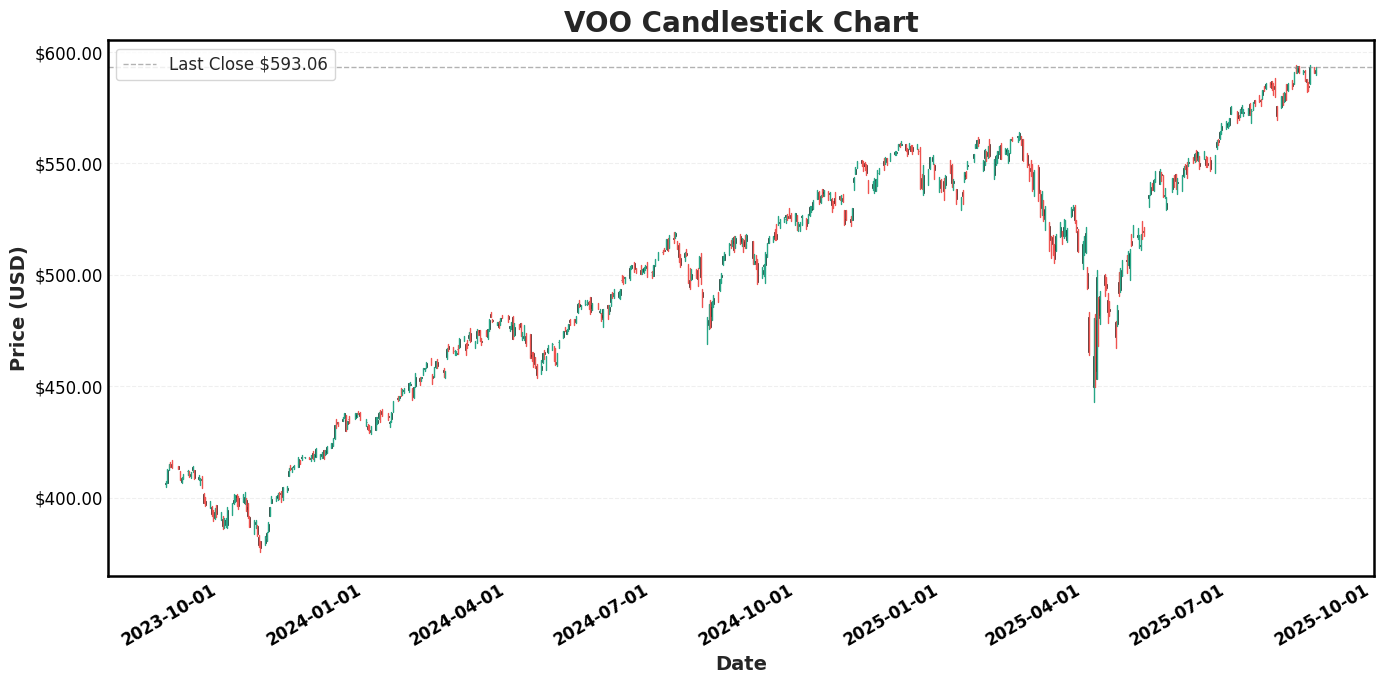

In [12]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 12

up_color = "#26a686"
down_color = "#ef5350"

historial_stock_data["timestamp"] = pd.to_datetime(historial_stock_data["timestamp"])

fig, ax = plt.subplots(figsize=(14, 7))

for _, row in historial_stock_data.iterrows():
    color = up_color if row["close"] >= row["open"] else down_color

    ax.plot([row["timestamp"], row["timestamp"]],
            [row["low"], row["high"]],
            color=color, linewidth=1.0, solid_capstyle="round")

    ax.add_patch(
        plt.Rectangle(
            (mdates.date2num(row["timestamp"]) - 0.25, min(row["open"], row["close"])),
            width=0.5,
            height=abs(row["close"] - row["open"]),
            facecolor=color,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.9
        )
    )

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontweight="bold")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.2f}"))

last_close = historial_stock_data["close"].iloc[-1]
ax.axhline(last_close, color="gray", linestyle="--", linewidth=1, alpha=0.6, label=f"Last Close ${last_close:.2f}")

ax.set_title(f"{ticker} Candlestick Chart", fontsize=20, fontweight="bold")
ax.set_ylabel("Price (USD)", fontsize=14, fontweight="bold")
ax.set_xlabel("Date", fontsize=14, fontweight="bold")

ax.legend(loc="upper left", frameon=True)

ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.3)
ax.grid(False, which="major", axis="x")

for spine in ax.spines.values():
    spine.set_linewidth(1.8)
    spine.set_color("black")

ax.tick_params(axis="both", which="major", labelsize=12, width=1.5, labelcolor="black")

plt.tight_layout()
plt.show()

In [14]:
from __future__ import annotations

def compute_indicators(
    df: pd.DataFrame,
    price_col: str = "vw",
    window_short: int = 10,
    window_long: int = 50,
    sharpe_windows: list[int] = [20, 60, 120]
) -> pd.DataFrame:
    df = df.copy()
    price = df[price_col]

    # Returns & moving averages
    df["ret_1"] = price.pct_change()
    df["sma_short"] = price.rolling(window_short, min_periods=1).mean()
    df["sma_long"] = price.rolling(window_long, min_periods=1).mean()
    df["ema_short"] = price.ewm(span=window_short, adjust=False).mean()
    df["ema_long"] = price.ewm(span=window_long, adjust=False).mean()

    # Momentum
    df["momentum"] = (df["sma_short"] - df["sma_long"]) / df["sma_long"]

    # Volatility (annualized)
    df["vol_20"] = df["ret_1"].rolling(20, min_periods=1).std() * np.sqrt(252)

    # RSI (14-day)
    delta = price.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14, min_periods=1).mean()
    roll_down = down.rolling(14, min_periods=1).mean()
    rs = roll_up / (roll_down + 1e-12)
    df["rsi"] = 100 - (100 / (1 + rs))

    # MACD
    ema_12 = price.ewm(span=12, adjust=False).mean()
    ema_26 = price.ewm(span=26, adjust=False).mean()
    df["macd"] = ema_12 - ema_26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

    # Z-score (20-day)
    rolling_mean = price.rolling(20, min_periods=1).mean()
    rolling_std = price.rolling(20, min_periods=1).std(ddof=0)
    df["zscore_20"] = (price - rolling_mean) / (rolling_std + 1e-12)

    # Skewness & kurtosis
    df["skew_20"] = price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).skew(), raw=False)
    df["kurt_20"] = price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).kurt(), raw=False)

    # Bollinger Bands
    bb_mid = price.rolling(20, min_periods=1).mean()
    bb_std = price.rolling(20, min_periods=1).std(ddof=0)
    df["bb_mid"] = bb_mid
    df["bb_upper"] = bb_mid + 2 * bb_std
    df["bb_lower"] = bb_mid - 2 * bb_std

    # Rolling Sharpe Ratios
    for w in sharpe_windows:
        roll_ret = df["ret_1"].rolling(w, min_periods=1)
        mean_ret = roll_ret.mean()
        std_ret = roll_ret.std(ddof=0)
        df[f"sharpe_{w}"] = (mean_ret / (std_ret + 1e-12)) * np.sqrt(252)

    return df.dropna()


def plot_indicators(indicators_df: pd.DataFrame, sharpe_windows=[20, 60, 120]) -> None:
    fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

    # Price & Bands
    axs[0].plot(indicators_df.index, indicators_df["vw"], label="VWAP", color="black")
    for col, color in [("sma_short", "blue"), ("sma_long", "red"), 
                       ("ema_short", "cyan"), ("ema_long", "magenta"),
                       ("bb_upper", "gray"), ("bb_mid", "orange"), ("bb_lower", "gray")]:
        axs[0].plot(indicators_df.index, indicators_df[col], label=col.replace("_", " ").title(), color=color)
    axs[0].set_title("Price, Moving Averages & Bollinger Bands")
    axs[0].legend()
    axs[0].grid(True)

    # Momentum & RSI
    axs[1].plot(indicators_df.index, indicators_df["momentum"], label="Momentum", color="green")
    ax2 = axs[1].twinx()
    ax2.plot(indicators_df.index, indicators_df["rsi"], label="RSI (14)", color="blue")
    ax2.set_ylim(0, 110)
    axs[1].set_title("Momentum & RSI")
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[1].legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.5))
    axs[1].grid(True)

    # MACD
    axs[2].plot(indicators_df.index, indicators_df["macd"], label="MACD", color="purple")
    axs[2].plot(indicators_df.index, indicators_df["macd_signal"], label="Signal", color="orange")
    axs[2].axhline(0, color="gray", linestyle="--")
    axs[2].set_title("MACD")
    axs[2].legend()
    axs[2].grid(True)

    # Volatility
    axs[3].plot(indicators_df.index, indicators_df["vol_20"], label="Volatility (20d)", color="brown")
    axs[3].set_title("Volatility")
    axs[3].legend()
    axs[3].grid(True)

    # Sharpe Ratios
    for w in sharpe_windows:
        axs[4].plot(indicators_df.index, indicators_df[f"sharpe_{w}"], label=f"Sharpe ({w}d)")
    axs[4].axhline(0, color="gray", linestyle="--")
    axs[4].set_title("Rolling Sharpe Ratios")
    axs[4].legend()
    axs[4].grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()



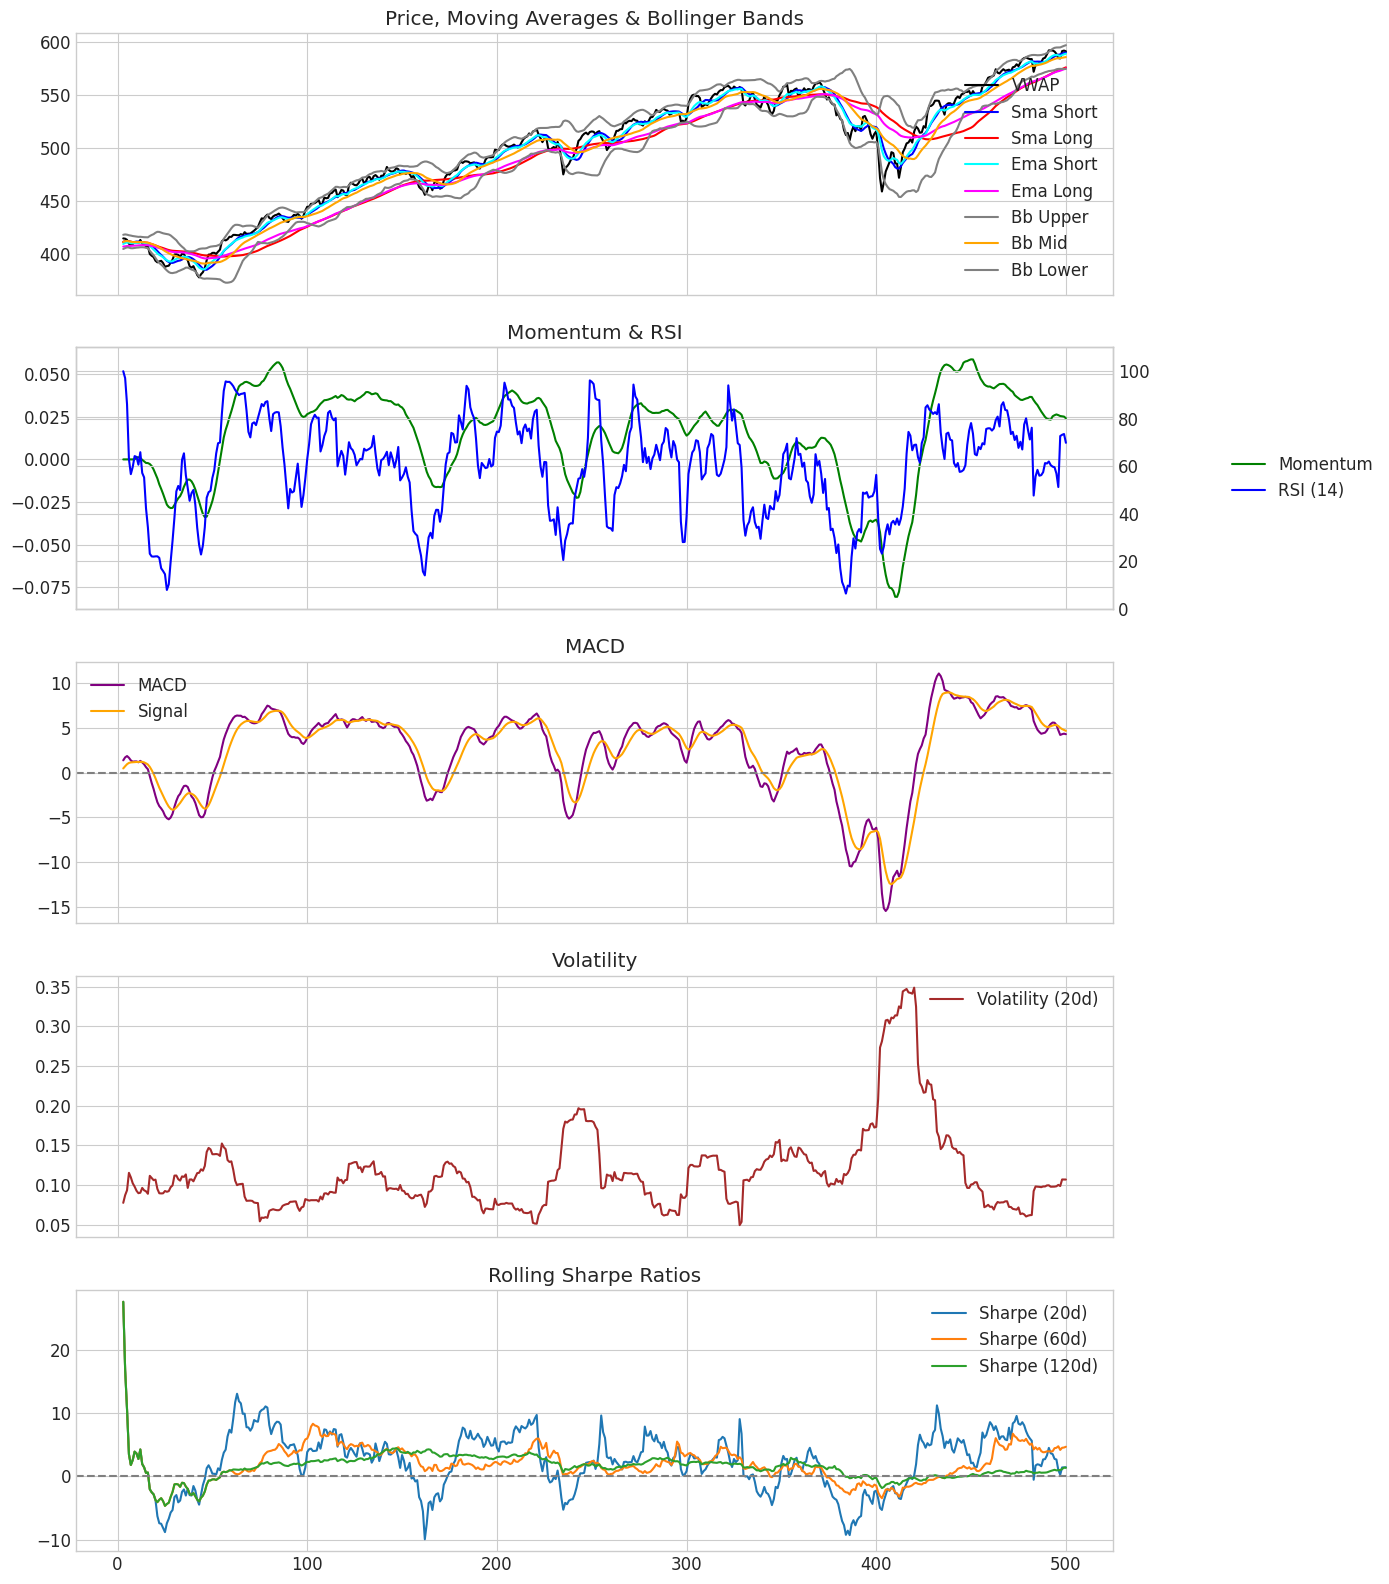

In [16]:
import numpy as np

indicators = compute_indicators(historial_stock_data, price_col='vw')
plot_indicators(indicators)